In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline 
plt.style.use('ggplot')

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from math import sqrt
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
## load data as time series 
df = pd.read_csv('a.us.txt', sep=",", 
                 header=0, 
                 index_col=0, 
                 parse_dates=True, 
                 squeeze=True)

In [4]:
df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1999-11-18,30.713,33.754,27.002,29.702,66277506,0
1999-11-19,28.986,29.027,26.872,27.257,16142920,0
1999-11-22,27.886,29.702,27.044,29.702,6970266,0
1999-11-23,28.688,29.446,27.002,27.002,6332082,0
1999-11-24,27.083,28.309,27.002,27.717,5132147,0


In [5]:
df['Close'].describe()

count    4521.000000
mean       27.871357
std        12.944389
min         7.323800
25%        19.089000
50%        24.490000
75%        36.521000
max       107.320000
Name: Close, dtype: float64

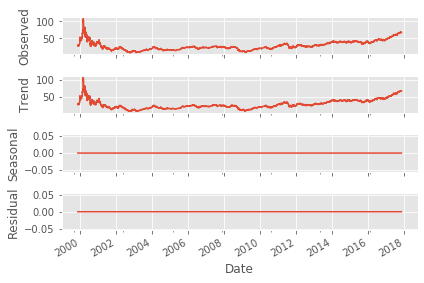

In [6]:
decompose = seasonal_decompose(df['Close'], model='additive', freq=1)

decompose.plot()
plt.show()

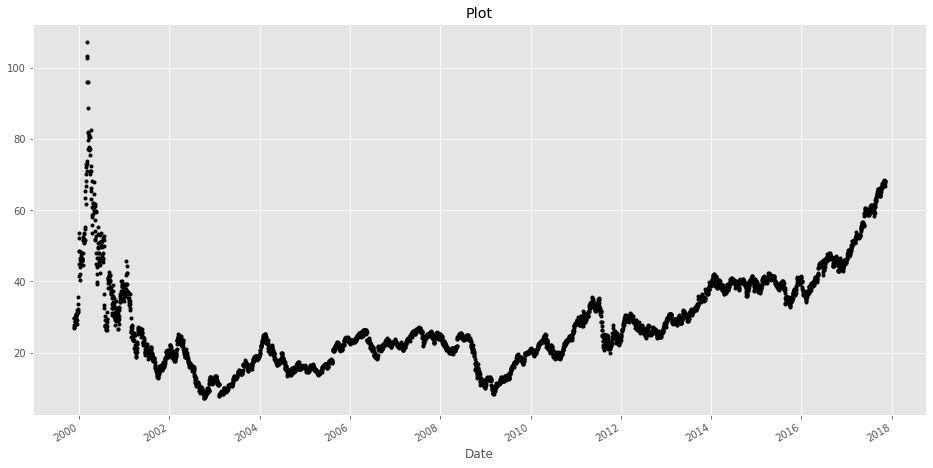

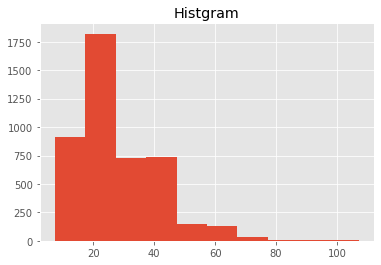

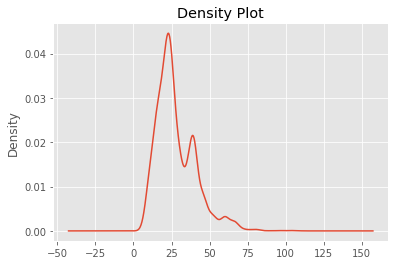

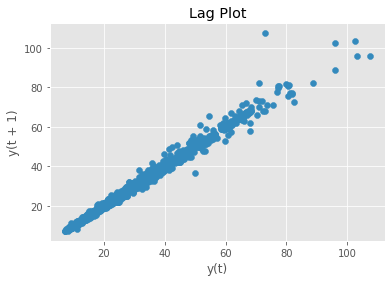

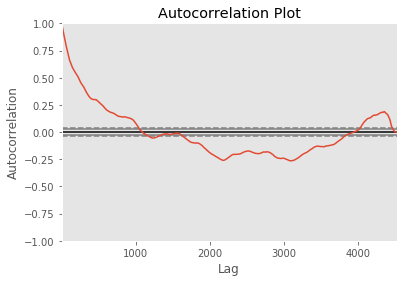

In [7]:
## visualize the dataset

df['Close'].plot(figsize=(16, 8), style='k.')
plt.title('Plot')
plt.show()

df['Close'].hist()
plt.title('Histgram')
plt.show()

df['Close'].plot(kind='kde')
plt.title('Density Plot')
plt.show()

pd.plotting.lag_plot(df['Close'])
plt.title('Lag Plot')
plt.show()

pd.plotting.autocorrelation_plot(df['Close'])
plt.title('Autocorrelation Plot')
plt.show()



### Downsampling

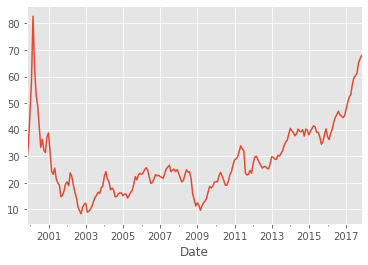

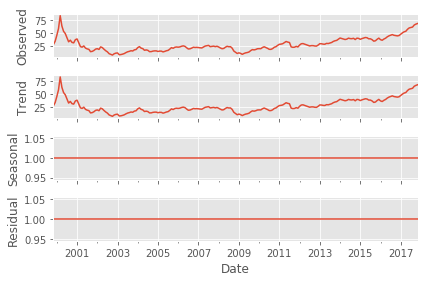

In [8]:
downsample = df['Close'].resample('M').mean()
downsample.plot()
plt.show()
results = seasonal_decompose(downsample, model='multiplicative', freq=1)
results.plot()
plt.show()

The data does not show seasonality, and decompose cannot catch the noise. 

## Build Persistence Model

In [15]:
X = df['Close'].values
X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0: train_size], X[train_size:]

history = [x for x in train]
predictions = list()

for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
#     print(f'Prediciton = {round(yhat,3)}, Expected = {round(obs, 3)}')
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f'RMSE: {round(rmse, 2)}')

RMSE: 0.5400000214576721


In [30]:
print(test)
p

array([11.906, 10.937, 11.672, ..., 68.11 , 67.47 , 66.81 ], dtype=float32)

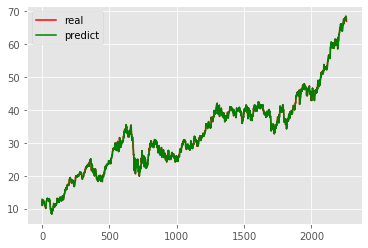

In [29]:
plt.figure()

plt.plot(test, color='red', label='real')
plt.plot(predictions, color='g', label='predict')
plt.legend()

plt.show()

## ARIMA Models

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return pd.Series(diff)

series = df['Close']
X = series.values

stationary = difference(X)
stationary.index = series.index[1:]

result=adfuller(stationary)

print(f'ADF statistics: {round(result[0], 3)}')
print(f'p_value: {round(result[1], 5)}')
print('critical values')
for k, v in result[4].items():
    print(k, round(v,3))

ADF statistics: -13.538
p_value: 0.0
critical values
1% -3.432
5% -2.862
10% -2.567


In [11]:
stationary.to_csv('stationary_stock.csv', header=False)

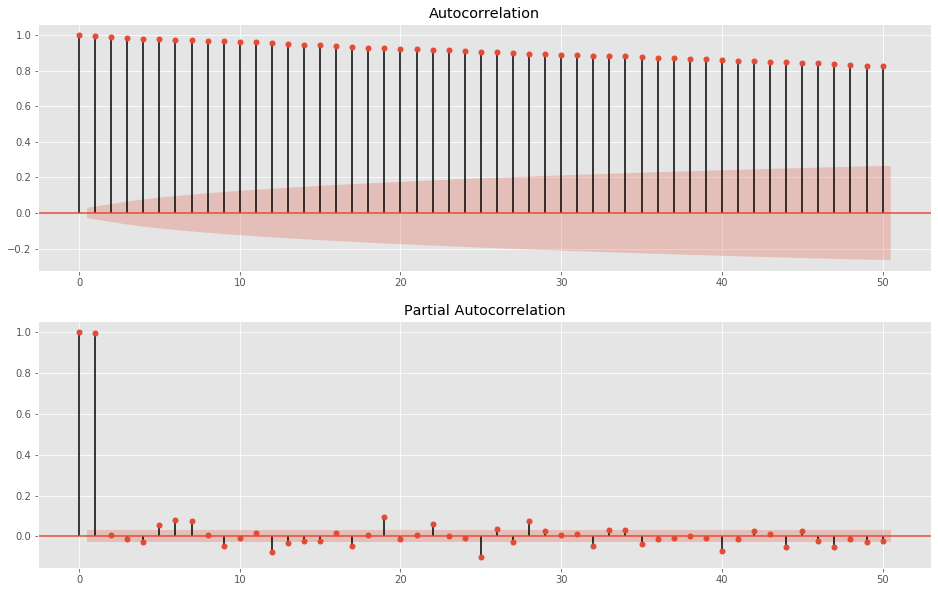

In [12]:
# ACF and PACF plots of time series:

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(16, 10))
plt.subplot(211)
plot_acf(df['Close'], lags=50, ax=plt.gca())

plt.subplot(212)
plot_pacf(df['Close'], lags=50, ax=plt.gca())

plt.show()

From the diffrencing, ACF, PACF, we can tell that the ARIMA with parameters of 1,1,1 might be the best.

In [13]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox

In [14]:
X = downsample.values
X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0: train_size], X[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)



1.6987126327459308


# Power transform data

In [15]:
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

In [16]:
X = downsample.values
X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0: train_size], X[train_size:]

history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    
    model = ARIMA(transformed, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    
    obs = test[i]
    history.append(obs)
    
#     print(f'Predicted={round(yhat, 3)}, Expected={round(obs, 3)}')
    
rsme = sqrt(mean_squared_error(test, predictions))
print(f'ERSM: {round(rsme, 3)}')   

ERSM: 1.673


In [17]:
import warnings

In [18]:
# grid search for p, d, q
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.5)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    prediction = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model.fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


def evaluate_models(dataset, ps, ds, qs):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in ps:
        for d in ds:
            for q in qs:
                order =(p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print(f'ARIMA: {order}, RMSE = {rmse}')
                except:
                    continue
    print(f'Best ARIMA: {best_cfg}, RMSE={best_score}')

In [19]:
ps = range(1, 5)
ds = range(1, 5)
qs = range(1, 5)

warnings.filterwarnings('ignore')
evaluate_models(downsample.values, ps, ds, qs)

Best ARIMA: None, RMSE=inf


Notes: the ARIMA model takes too long time. 

## Long Short Term Memory 

In [466]:
## load data as time series 
df1 = pd.read_csv('cag.us.txt', sep=",", 
                 header=0
                 )

In [467]:
df1.describe()

,Open,High,Low,Close,Volume,OpenInt
count,8362.000000,8362.000000,8362.000000,8362.000000,8.362000e+03,8362.0
mean,17.008013,17.160866,16.847998,17.012783,2.351712e+06,0.0
std,10.135231,10.208821,10.063380,10.139211,2.208917e+06,0.0
min,1.446300,1.446300,1.421500,1.446300,0.000000e+00,0.0
25%,8.586500,8.668300,8.512600,8.594700,8.612980e+05,0.0
50%,17.831000,17.995000,17.636500,17.831000,1.664544e+06,0.0
75%,21.529250,21.693000,21.356000,21.536750,3.229892e+06,0.0
max,47.079000,47.764000,46.910000,47.589000,3.598559e+07,0.0


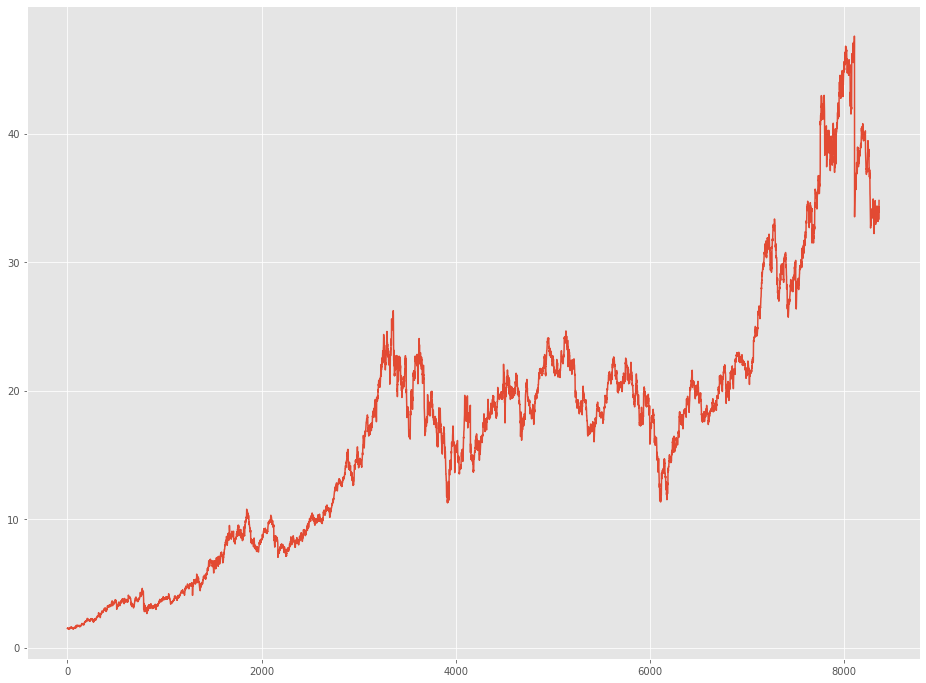

In [468]:
df1['Close'].plot(figsize=(16,12))

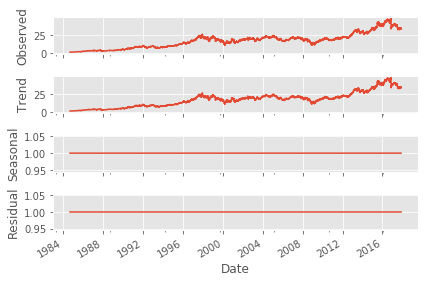

In [245]:
results = seasonal_decompose(df1['Close'], model='multiplicative', freq=1)
# plt.figure(figsize=(50,12))
results.plot()
plt.show()

## Normalize the data

In [246]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [247]:
X = df1['Close'].values
X = X.astype('float32')

train_size = int(len(X) * 0.90)
train, test = X[0: train_size], X[train_size:]

train_data = train.reshape(-1,1)
test_data = test.reshape(-1,1)

By set up the smooting widow size as 2200, where will be 3 data points be affected, which is fine for the dataset size.

Feature normalization:

1. Scaling: Standard Scaler z = (x-u) / s 
            Min Max Scale:xit = (x_i - x_i_min) / (x_i_max - x_i_min)
            Normalizer: scales each data point such that the featuer vetor has a Euclidean length of 1, and often used when the direction of the data matters, not the feature vector.
            
2. Pipeline: from sklearn.pipeline import Pipeline

pip = Pipleline[('s', MinMaxScaler(copy=True), ('lr', LinearRegression())]

In this case, MinMaxScaler was used for normalization. Because the stock price strike a lot and some values might be close to zero when using MinMaxScaler, so that window normalization is used.

In [248]:
smoothing_window_size = 2200
for di in range(0,6600,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [249]:
train_data.size

7525

In [250]:
train_data = train_data.reshape(-1)

In [251]:
test_data=scaler.transform(test_data).reshape(-1)

In [252]:
test_data.size

837

## Smooth the data

Smoothing is usually done to help better see patterns in time series. Generally, smooth out of irregular roughness to see a clearer signal. 

The term filter is sometimes used to describe a smoothing procedure. For instance, if the smoothed value for a particular time is calculated as a linear combination of observations for surrounding times, it might be said that we have applied a linear filter to the data. 

More about smooth: https://online.stat.psu.edu/stat510/lesson/5/5.2

Exponential moving acerage is used to remove the inherent raggedness of the data in this case. 

x(t_1)_hat = gamma * x(t) + (1-gamma)* x(t)_hat

Only need to smooth trainning data. 

In [253]:
EMA = 0.0
gamma = 0.2

for t in range(6689):
    EMA = gamma * train_data[t] + (1-gamma) * EMA
    train_data[t] = EMA
    
all_data = np.concatenate([train_data, test_data], axis=0)
    

In [254]:
all_data

array([0.0012345 , 0.00204207, 0.0033911 , ..., 1.0592798 , 1.0373937 ,
       1.0899199 ], dtype=float32)

In [255]:
# Standard moving average model: which allows to predict one time step ahead by representing the future stock price
# as an average of the previously observed stock prices. Doing this for more than one step can produce quite
# bad results. 

window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size, N):
    
#     std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)  

In [256]:
print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00469


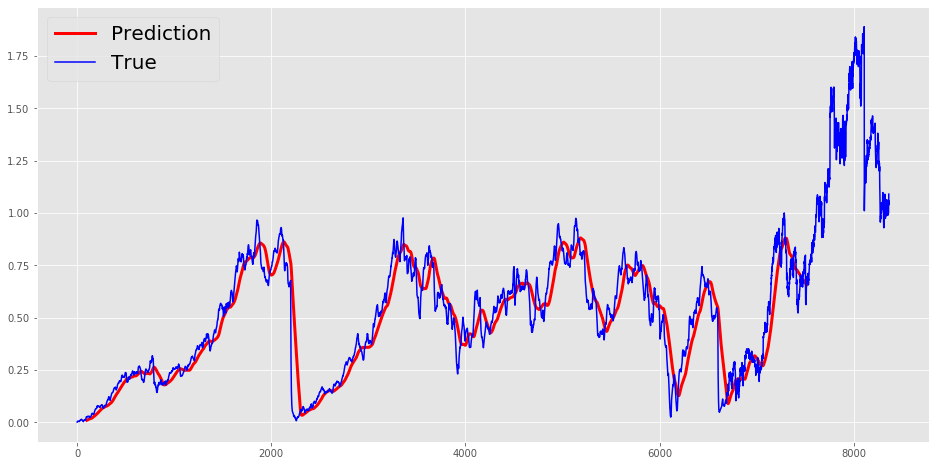

In [257]:
plt.figure(figsize=(16,8))

plt.plot(range(window_size,N),std_avg_predictions,color='r', linewidth=3, label='Prediction')
plt.plot(range(df1['Close'].shape[0]),all_data,color='b',label='True')
plt.legend(fontsize=(20))
plt.show()

#### LSTM model

Why LSTM model: 

LSTM model is able to predict more than one step into the future. LSTM is very powerful time series models that can predict arbitrary number of steps into the future. 

LSTM model has five essential components which allows it to model both long-term and short-term data.

1. Cell state (Ct) - This represents the internal memory of the cell which stores both short term memory and long-term memories.
2. Hidden state(ht) - This is output state information calculated with current input which we eventually use to predict the future stock market prices. The hidden state can decide to only retrive the short or long term or both types of memory stored in the cell state to make the next prediction.
3. Input gate(it) - Decides how much information from current flows to the cell state.
4. Forget gate(ft) - Decides how much information from the current input and the previous cell state flows into the current cell state.
5. Output gate(ot) - Decides how much information from the current cell state flows into the hidden state, so that if needed LSTM can only pick the long-term memories or short-term memories and long long-term memories.

x(t) = 0.4, EMA = 0.5, and gamma = 0.5

we want the output with the following equation:

X(t+1) = EMA(t) = gamma * EMA(t-1) + (1-gamma) * X(t)


In [258]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.0012345  0.53603977 0.3795764  0.578475   0.43591365]

	Output: [0.0033911  0.50718135 0.38515785 0.595972   0.45613098]


Unrolled index 1
	Inputs:  [0.00204207 0.5283228  0.3822003  0.59018254 0.44549248]

	Output: [0.0033911  0.505774   0.3904465  0.62332714 0.47415155]


Unrolled index 2
	Inputs:  [0.0033911  0.51687044 0.38515785 0.595972   0.45613098]

	Output: [0.00498008 0.51687044 0.38830075 0.6172384  0.45613098]


Unrolled index 3
	Inputs:  [0.00447033 0.50718135 0.38666543 0.6102662  0.46144095]

	Output: [0.00498008 0.505774   0.39089635 0.6172384  0.46144095]


Unrolled index 4
	Inputs:  [0.00498008 0.505774   0.38830075 0.6172384  0.4664403 ]

	Output: [0.00538788 0.51836354 0.3903978  0.6217513  0.47935596]


In [299]:
data1 = df1['Close']


In [447]:
df1

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1984-09-07,1.5039,1.5202,1.4789,1.5039,269452,0
1984-09-10,1.5039,1.5202,1.4789,1.4955,231661,0
1984-09-11,1.5039,1.5283,1.5039,1.5283,785353,0
1984-09-12,1.5283,1.5283,1.5118,1.5283,1284825,0
1984-09-13,1.5283,1.5283,1.5039,1.5118,377887,0
...,...,...,...,...,...,...
2017-11-06,33.8400,33.9300,33.2400,33.3200,2869514,0
2017-11-07,33.3200,33.7600,33.2100,33.7600,2436664,0
2017-11-08,33.8500,34.3800,33.8500,34.3100,2044805,0


In [478]:
train_set = df1.iloc[:7000, 4:5].values
test_set = df1.iloc[7000:, 4:5].values

In [479]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(50, 7000):
    X_train.append(training_set_scaled[i-50:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [480]:
X_train.shape

(6950, 50, 1)

In [481]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Train on 6950 samples
Epoch 1/10
6950/6950 [==============================] - 16s 2ms/sample - loss: 0.0097
Epoch 2/10
6950/6950 [==============================] - 13s 2ms/sample - loss: 0.0034
Epoch 3/10
6950/6950 [==============================] - 13s 2ms/sample - loss: 0.0031
Epoch 4/10
6950/6950 [==============================] - 13s 2ms/sample - loss: 0.0027
Epoch 5/10
6950/6950 [==============================] - 13s 2ms/sample - loss: 0.0025
Epoch 6/10
6950/6950 [==============================] - 13s 2ms/sample - loss: 0.0024
Epoch 7/10
6950/6950 [==============================] - 13s 2ms/sample - loss: 0.0021
Epoch 8/10
6950/6950 [==============================] - 13s 2ms/sample - loss: 0.0019
Epoch 9/10
6950/6950 [==============================] - 13s 2ms/sample - loss: 0.0017
Epoch 10/10
6950/6950 [==============================] - 13s 2ms/sample - loss: 0.0018


In [511]:
dataset_train = df1.iloc[:8000, 4:5]
dataset_test = df1.iloc[8000:, 4:5]

dataset_total = pd.concat((dataset_train, dataset_test), axis=0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 362):
    X_test.append(inputs[i-50:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(302, 50, 1)


In [516]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# dataset_test['Predicted'] = predicted_stock_price

In [523]:
len(predicted_stock_price)

302

In [525]:
dataset_test_1 = df1.iloc[8060:, :]
dataset_test_1['predicted'] = predicted_stock_price

In [531]:
dataset_test_1

,Date,Open,High,Low,Close,Volume,OpenInt,predicted
8060,2016-09-01,45.133,45.322,44.511,44.754,2588773,0,39.237514
8061,2016-09-02,44.900,45.484,44.861,45.356,1610153,0,39.452374
8062,2016-09-06,45.299,45.415,44.910,45.133,1655403,0,39.565605
8063,2016-09-07,45.016,45.123,44.452,44.577,1988153,0,39.579109
8064,2016-09-08,44.365,44.375,43.635,43.644,4537710,0,39.488522
...,...,...,...,...,...,...,...,...
8357,2017-11-06,33.840,33.930,33.240,33.320,2869514,0,31.525536
8358,2017-11-07,33.320,33.760,33.210,33.760,2436664,0,31.513828
8359,2017-11-08,33.850,34.380,33.850,34.310,2044805,0,31.561029
8360,2017-11-09,33.960,34.480,33.960,33.960,2177336,0,31.664646


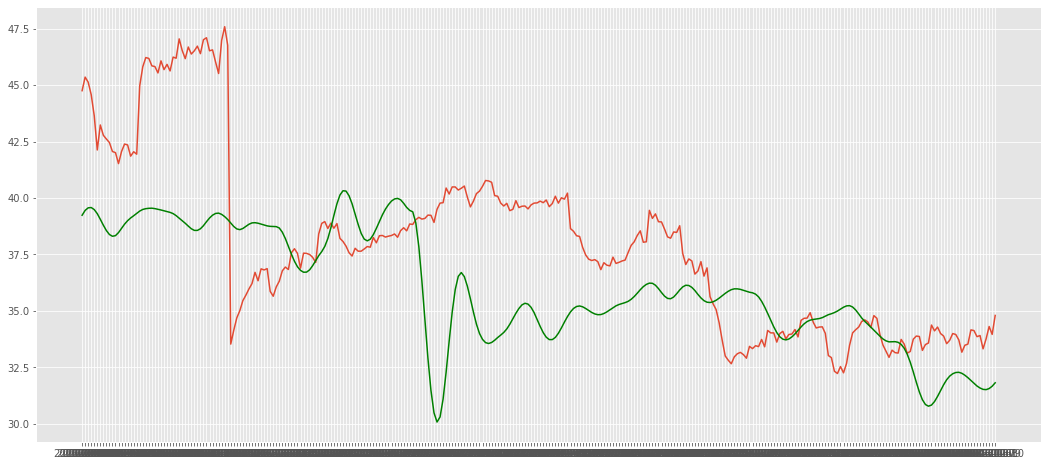

In [530]:
# Visualising the results
plt.plot(dataset_test_1['Date'], dataset_test_1['Close'])
plt.plot(dataset_test_1['Date'], dataset_test_1['predicted'], color ='green')


In [432]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 50
n_features= 1
generator = TimeseriesGenerator(training_set_scaled, training_set_scaled, length=n_input, batch_size=1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [435]:
# lstm_model.fit_generator(generator,epochs=20)

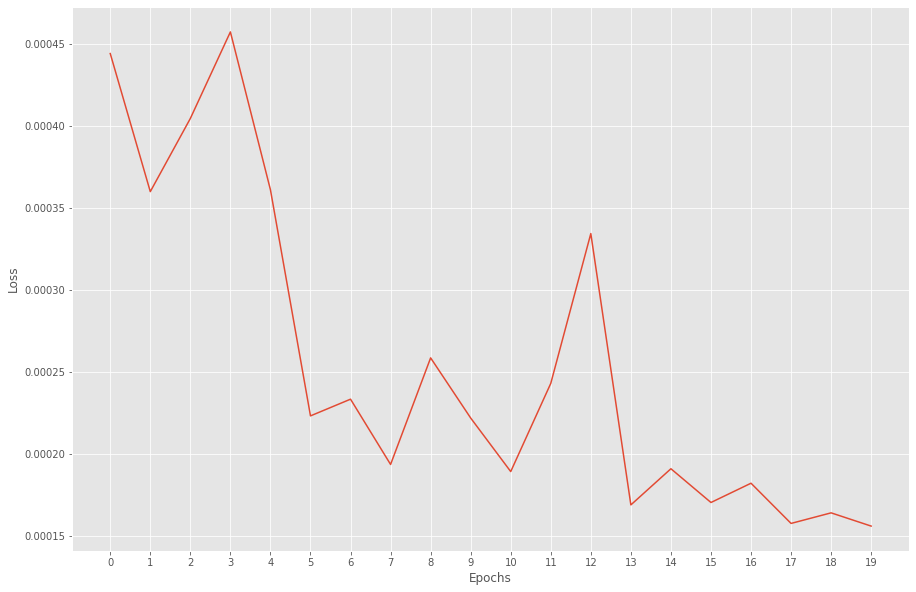

In [423]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(15,10))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [424]:
lstm_predictions_scaled = list()

batch = training_set_scaled[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:], [[lstm_pred]], axis=1)

In [425]:
len(lstm_predictions_scaled)

1362

In [426]:
lstm_predictions = sc.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[20.72587612],
       [20.3709486 ],
       [19.94542732],
       ...,
       [ 2.84620836],
       [ 2.84620836],
       [ 2.84620836]])

In [427]:
test_data = df1.iloc[7000:, :]
test_data['LSTM_Predicitons'] = lstm_predictions

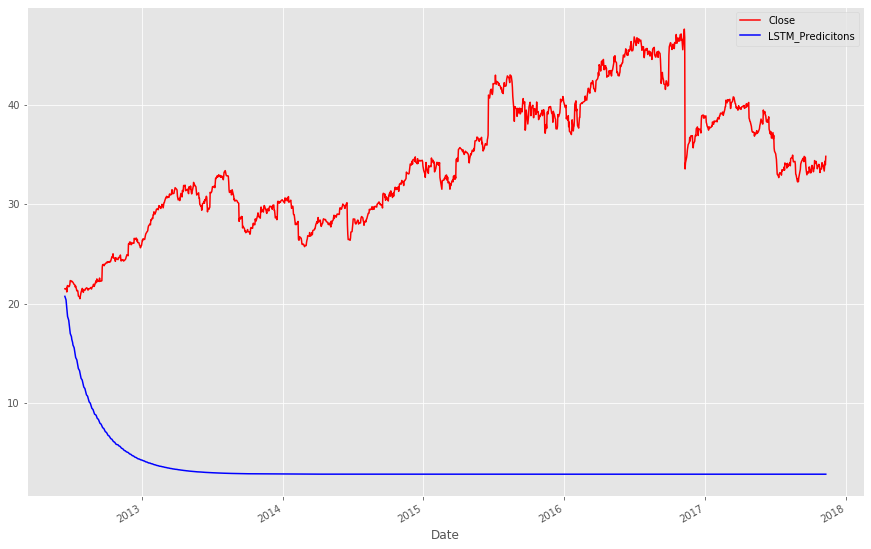

In [429]:
test_data['Close'].plot(figsize=(15,10), color='r', legend=True)
test_data['LSTM_Predicitons'].plot(color = 'b', legend=True)

In [430]:
test_data

,Open,High,Low,Close,Volume,OpenInt,LSTM_Predicitons
Date,,,,,,,
2012-06-15,21.375,21.496,21.323,21.486,4092920,0,20.725876
2012-06-18,21.313,21.503,21.313,21.468,2837376,0,20.370949
2012-06-19,21.520,21.665,21.397,21.545,2699318,0,19.945427
2012-06-20,21.513,21.554,21.054,21.167,5831954,0,19.514330
2012-06-21,21.451,22.122,21.404,21.736,13376872,0,19.096739
...,...,...,...,...,...,...,...
2017-11-06,33.840,33.930,33.240,33.320,2869514,0,2.846208
2017-11-07,33.320,33.760,33.210,33.760,2436664,0,2.846208
2017-11-08,33.850,34.380,33.850,34.310,2044805,0,2.846208
